<!--COURSE_INFORMATION-->
*This notebook contains material from [ND Pyomo Cookbook](http://jckantor.github.io/ND-Pyomo-Cookbook/) by Jeffrey Kantor (jeff at nd.edu); the content is available [on GitHub](https://github.com/jckantor/ND-Pyomo-Cookbook).*
*The text is released under the [CC-BY-NC-ND-4.0 license](https://creativecommons.org/licenses/by-nc-nd/4.0/legalcode), and code is released under the [MIT license](https://opensource.org/licenses/MIT).*


<!--NAVIGATION-->
< [Job Shop Scheduling](04.02-Job-Shop-Scheduling.ipynb) | [Contents](index.ipynb) | [Scheduling Multipurpose Batch Processes using State-Task Networks](04.04-Scheduling-Multipurpose-Batch-Processes-using-State-Task_Networks.ipynb) >

<a href="https://colab.research.google.com/github/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/04.03-Maintenance-Planning.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>


# Maintenance Planning

## Problem Statement


A process unit is operating over a maintenance planning horizon from $1$ to $T$ days.  On day $t$ the unit makes a profit $c[t]$ which is known in advance. The unit needs to shut down for $P$ maintenance periods during the planning period.  Once started, a maintenance period takes $M$ days to finish.

Find a maintenance schedule that allows the maximum profit to be produced.

## Modeling with Disjunctive Constraints

The model is comprised of two sets of the binary variables indexed 1 to $T$. Binary variables $x_t$ correspond to the operating mode of the process unit, with $x_t=1$ indicating the unit is operating on day $t$ and able to earn a profit $c_t$. Binary variable $y_t=1$ indicates the first day of a maintenance period during which the unit is not operating and earning $0$ profit.

### Objective

The planning objective is to maximize profit

\begin{align*}
\mbox{Profit} & = \max_{x, y} \sum_{t=1}^T c_t x_t
\end{align*}

subject to completing $P$ maintenance periods.  

### Constraints

#### Number of planning periods is equal to P.

Completing $P$ planning periods requires

\begin{align*}
\sum_{t=1}^T y_t &  = P \\
\end{align*}

#### No more than one maintenance period can start in any consecutive set of M days.

No more than one maintenance period can start in any consecutive set of M days.

\begin{align*}
\sum_{s=0}^{M-1}y_{t+s} & \leq 1 \qquad \forall t = 1, 2, \ldots, T-M+1
\end{align*}

This last requirement could be modified if some period of time should occur between maintenance periods.

#### The unit must shut down for M days following a maintenance start.

The final requirement is a disjunctive constraint that says either $y_t = 0$ or the sum $\sum_{s}^{M-1}x_{t+s} = 0$, but not both. Mathematically, this forms a set of constraints reading

\begin{align*}
\left(y_t = 0\right) \lor \left(\sum_{s=0}^{M-1}x_{t+s} = 0\right)\qquad \forall t = 1, 2, \ldots, T-M+1
\end{align*}

where $\lor$ denotes a disjunction.



## Pyomo Solution using the Generalized Disjunctive Constraints Extension

### Initialization for Google Colaboratory

If you are running this in Google Colaboratory, execute the following cell to install Pyomo and the COIN-OR CBC that are needed to execute the code in this notebook. If not run in Google Colaboratory, then please verify that Pyomo and the COIN-OR CBC solver have been successfully installed before attempting to run the code in this notebook.

In [0]:
%%capture
!pip install -q pyomo
!apt-get install -y -qq coinor-cbc

### Parameter Values

In [0]:
import numpy as np

# problem parameters
T = 90        # planning period from 1..T
M = 3         # length of maintenance period
P = 4         # number of maintenance periods

# daily profits
c = {k:np.random.uniform() for k in range(1, T+1)}

### Pyomo Model

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: -44.83878144
  Upper bound: -44.83878144
  Number of objectives: 1
  Number of constraints: 3786
  Number of variables: 2557
  Number of nonzeros: 8537
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  Termination condition: optimal
  Error rc: 0
  Time: 0.192549467086792
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutio

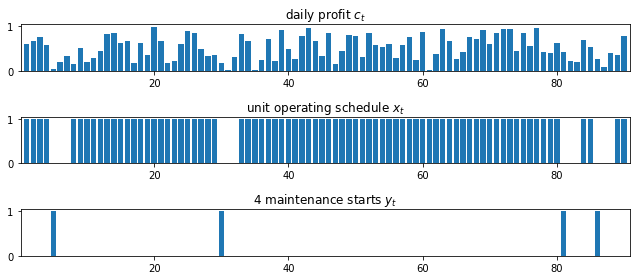

In [49]:
import pyomo.environ as pyo
import pyomo.gdp as gdp
import matplotlib.pyplot as plt

def maintenance_planning_gdp(c, T, M, P):
    m = pyo.ConcreteModel()

    m.T = pyo.RangeSet(1, T)
    m.Y = pyo.RangeSet(1, T-M+1)
    m.S = pyo.RangeSet(0, M-1)

    m.c = pyo.Param(m.T, initialize = c)
    m.x = pyo.Var(m.T, domain=pyo.Binary)
    m.y = pyo.Var(m.T, domain=pyo.Binary)

    # objective
    m.profit = pyo.Objective(expr = sum(m.c[t]*m.x[t] for t in m.T), sense=pyo.maximize)

    # required number P of maintenance starts
    m.sumy = pyo.Constraint(expr = sum(m.y[t] for t in m.Y) == P)

    # no more than one maintenance start in the period of length M
    m.sprd = pyo.Constraint(m.Y, rule = lambda m, t: sum(m.y[t+s] for s in m.S) <= 1)

    # disjunctive constraints
    m.disj = gdp.Disjunction(m.Y, m.S, rule = lambda m, t, s: [m.y[t]==0, sum(m.x[t+s] for s in m.S)==0])

    # transformation and soluton
    pyo.TransformationFactory('gdp.chull').apply_to(m)
    
    return m


def plot_schedule(m):
    fig,ax = plt.subplots(3,1, figsize=(9,4))
    
    ax[0].bar(m.T, [m.c[t] for t in m.T])
    ax[0].set_title('daily profit $c_t$')
    
    ax[1].bar(m.T, [m.x[t]() for t in m.T], label='normal operation')
    ax[1].set_title('unit operating schedule $x_t$')
    
    ax[2].bar(m.Y, [m.y[t]() for t in m.Y])
    ax[2].set_title(str(P) + ' maintenance starts $y_t$')
    for a in ax:
        a.set_xlim(0.1, len(m.T)+0.9)
        
    plt.tight_layout()

  
m = maintenance_planning_gdp(c, T, M, P)
pyo.SolverFactory('cbc').solve(m).write()
plot_schedule(m)

## Pyomo Solution Replacing Disjunctive Constraints using Big-M

These disjunctive constraints can be implemented using the big-M method.  In particular,

\begin{align*}
\sum_{s=0}^{M-1}x_{t+s} \leq M(1-y_t) \qquad \forall t = 1, 2, \ldots, T-M+1
\end{align*}

Alternatively, the disjunctive constraints can be represented directly in Pyomo using the [Generalized Disjunctive Programming](https://pyomo.readthedocs.io/en/latest/modeling_extensions/gdp.html) extension. The advantage of using the extension is that constraints can be transformed to an MILP using alternatives to the big-M, such as convex hull and cutting plane methods.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: -44.83878144
  Upper bound: -44.83878144
  Number of objectives: 1
  Number of constraints: 354
  Number of variables: 181
  Number of nonzeros: 1409
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  Termination condition: optimal
  Error rc: 0
  Time: 0.0720376968383789
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solution

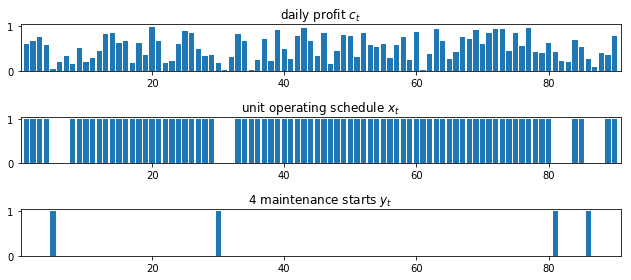

In [50]:
import pyomo.environ as pyo
import matplotlib.pyplot as plt

def maintenance_planning_bigm(c, T, M, P):
    m = pyo.ConcreteModel()

    m.T = pyo.RangeSet(1, T)
    m.Y = pyo.RangeSet(1, T-M+1)
    m.S = pyo.RangeSet(0, M-1)

    m.c = pyo.Param(m.T, initialize = c)
    m.x = pyo.Var(m.T, domain=pyo.Binary)
    m.y = pyo.Var(m.T, domain=pyo.Binary)

    # objective
    m.profit = pyo.Objective(expr = sum(m.c[t]*m.x[t] for t in m.T), sense=pyo.maximize)

    # required number P of maintenance starts
    m.sumy = pyo.Constraint(expr = sum(m.y[t] for t in m.Y) == P)

    # no more than one maintenance start in the period of length M
    m.sprd = pyo.Constraint(m.Y, rule = lambda m, t: sum(m.y[t+s] for s in m.S) <= 1)

    # disjunctive constraints
    m.bigm = pyo.Constraint(m.Y, m.S, rule = lambda m, t, s: sum(m.x[t+s] for s in m.S) <= M*(1 - m.y[t]))
    
    return m
   
m = maintenance_planning_bigm(c, T, M, P)
pyo.SolverFactory('cbc').solve(m).write()
plot_schedule(m)

## Ramping Constraints

Prior to maintenance shutdown, a large processing unit may take some time to safely ramp down from full production. And then require more time to safely ramp back up to full production following maintenace. To provide for ramp-down and ramp-up periods, we modify the problem formation in the following ways.

* The variable denoting unit operation, $x_t$ is changed from a binary variable to a continuous variable $\0 \leq x_t \leq 1$ denoting the fraction of total capacity at which the unit is operating on day $t$.

* Two new variable sequences, $0 \leq u_t^+ \leq u_t^{+,\max}$ and $0\leq u_t^- \leq u_t^{-,\max}$, are introduced which denote the fraction increase or decrease in unit capacity to completed on day $t$.

* An additional sequence of equality constraints is introduced relating $x_t$ to $u_t^+$ and $u_t^-$.

\begin{align*}
x_{t} & = x_{t-1} + u^+_t - u^-_t
\end{align*}

We begin the Pyomo model by specifying the constraints, then modifying the Big-M formulation to add the features described above.

In [0]:
upos_max = 0.3334
uneg_max = 0.5000

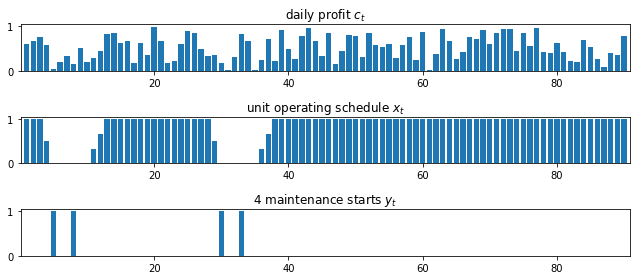

In [53]:
import pyomo.environ as pyo
import pyomo.gdp as gdp
import matplotlib.pyplot as plt

def maintenance_planning_ramp(c, T, M, P):
    m = pyo.ConcreteModel()

    m.T = pyo.RangeSet(1, T)
    m.Y = pyo.RangeSet(1, T-M+1)
    m.S = pyo.RangeSet(0, M-1)

    m.c = pyo.Param(m.T, initialize = c)
    m.x = pyo.Var(m.T, bounds=(0, 1))
    m.y = pyo.Var(m.T, domain=pyo.Binary)
    m.upos = pyo.Var(m.T, bounds=(0, upos_max))
    m.uneg = pyo.Var(m.T, bounds=(0, uneg_max))

    # objective
    m.profit = pyo.Objective(expr = sum(m.c[t]*m.x[t] for t in m.T), sense=pyo.maximize)
    
    # ramp constraint
    m.ramp = pyo.Constraint(m.T, rule = lambda m, t: 
         m.x[t] == m.x[t-1] + m.upos[t] - m.uneg[t] if t > 1 else pyo.Constraint.Skip)
      
    # required number P of maintenance starts
    m.sumy = pyo.Constraint(expr = sum(m.y[t] for t in m.Y) == P)

    # no more than one maintenance start in the period of length M
    m.sprd = pyo.Constraint(m.Y, rule = lambda m, t: sum(m.y[t+s] for s in m.S) <= 1)
    
    # disjunctive constraints
    m.bigm = pyo.Constraint(m.Y, m.S, rule = lambda m, t, s: sum(m.x[t+s] for s in m.S) <= M*(1 - m.y[t]))
    
    return m

  
m = maintenance_planning_gdp(c, T, M, P)
pyo.SolverFactory('cbc').solve(m)
plot_schedule(m)

## Introducing a Minimum Number of Operational Days between Maintenance Periods

In [0]:
N = 10  # minimum number of operational days between maintenance periods

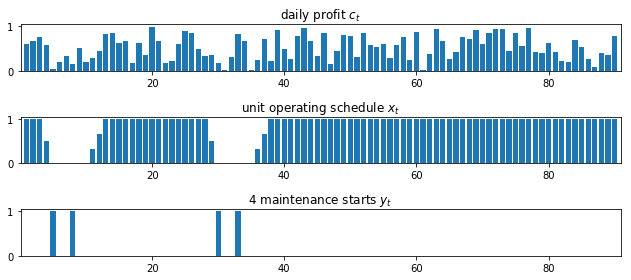

In [59]:
import pyomo.environ as pyo
import pyomo.gdp as gdp
import matplotlib.pyplot as plt

def maintenance_planning_ramp(c, T, M, P):
    m = pyo.ConcreteModel()

    m.T = pyo.RangeSet(1, T)
    m.Y = pyo.RangeSet(1, T-M+1)
    m.S = pyo.RangeSet(0, M-1)
    m.W = pyo.RangeSet(0, M+N-1)

    m.c = pyo.Param(m.T, initialize = c)
    m.x = pyo.Var(m.T, bounds=(0, 1))
    m.y = pyo.Var(m.T, domain=pyo.Binary)
    m.upos = pyo.Var(m.T, bounds=(0, upos_max))
    m.uneg = pyo.Var(m.T, bounds=(0, uneg_max))

    # objective
    m.profit = pyo.Objective(expr = sum(m.c[t]*m.x[t] for t in m.T), sense=pyo.maximize)
    
    # ramp constraint
    m.ramp = pyo.Constraint(m.T, rule = lambda m, t: 
         m.x[t] == m.x[t-1] + m.upos[t] - m.uneg[t] if t > 1 else pyo.Constraint.Skip)
      
    # required number P of maintenance starts
    m.sumy = pyo.Constraint(expr = sum(m.y[t] for t in m.Y) == P)

    # no more than one maintenance start in the period of length M
    m.sprd = pyo.Constraint(m.T, rule = lambda m, t: sum(m.y[t+s] for s in m.W and t + s <= T) <= 1)
    
    # disjunctive constraints
    m.bigm = pyo.Constraint(m.Y, m.S, rule = lambda m, t, s: sum(m.x[t+s] for s in m.S) <= M*(1 - m.y[t]))
    
    return m

  
m = maintenance_planning_gdp(c, T, M, P)
pyo.SolverFactory('cbc').solve(m)
plot_schedule(m)

## Exercise

Rather than specify how many maintenance periods must be accomodated, modify the model so that the process unit can operate no more than $N$ days without a maintenance shutdown.  (Hint. You may to introduce an additional set of binary variables, $z_t$ to denote the start of an operational period.)

<!--NAVIGATION-->
< [Job Shop Scheduling](04.02-Job-Shop-Scheduling.ipynb) | [Contents](index.ipynb) | [Scheduling Multipurpose Batch Processes using State-Task Networks](04.04-Scheduling-Multipurpose-Batch-Processes-using-State-Task_Networks.ipynb) >

<a href="https://colab.research.google.com/github/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/04.03-Maintenance-Planning.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>
